In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import glob
import scipy.optimize as sco
import torch
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


data

Unexpected error while processing MMM: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

Insufficient data for ABNB: Data is empty or contains less than 1000 records (768 records if not empty)




1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 1 failed for AMTM. Retrying after delay...



1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 2 failed for AMTM. Retrying after delay...



1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Failed to download data for AMTM after 3 attempts.
ValueError for AMTM: Empty data received

Insufficient data for CARR: Data is empty or contains less than 1000 records (953 records if not empty)

Insufficient data for CEG: Data is empty or contains less than 1000 records (490 records if not empty)

Insufficient data for GEHC: Data is empty or contains less than 1000 records (261 records if not empty)




1 Failed download:
['GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 1 failed for GEV. Retrying after delay...



1 Failed download:
['GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 2 failed for GEV. Retrying after delay...



1 Failed download:
['GEV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Failed to download data for GEV after 3 attempts.
ValueError for GEV: Empty data received

Insufficient data for KVUE: Data is empty or contains less than 1000 records (166 records if not empty)

Insufficient data for OTIS: Data is empty or contains less than 1000 records (953 records if not empty)

Insufficient data for PLTR: Data is empty or contains less than 1000 records (818 records if not empty)




1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 1 failed for SW. Retrying after delay...



1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 2 failed for SW. Retrying after delay...



1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Failed to download data for SW after 3 attempts.
ValueError for SW: Empty data received




1 Failed download:
['SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 1 failed for SOLV. Retrying after delay...



1 Failed download:
['SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Attempt 2 failed for SOLV. Retrying after delay...



1 Failed download:
['SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2013-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1357016400, endDate = 1703998800")')


Failed to download data for SOLV after 3 attempts.
ValueError for SOLV: Empty data received

Insufficient data for VLTO: Data is empty or contains less than 1000 records (61 records if not empty)

Top 20 Stocks by Market Capitalization:
    Ticker      MarketCap
36    AAPL  3553119698944
341   NVDA  3353170935808
311   MSFT  3182054342656
20    AMZN  2185648013312
17   GOOGL  2078501634048
18    GOOG  2078492721152
305   META  1447895891968
432   TSLA  1085738647552
57   BRK-B  1032349548544
69    AVGO   769431437312
470    WMT   733972594688
281    LLY   709848072192
261    JPM   703750537216
463      V   603424751616
453    UNH   558419148800
350   ORCL   527526658048
182    XOM   518488752128
298     MA   485055299584
125   COST   430446379008
227     HD   426669277184


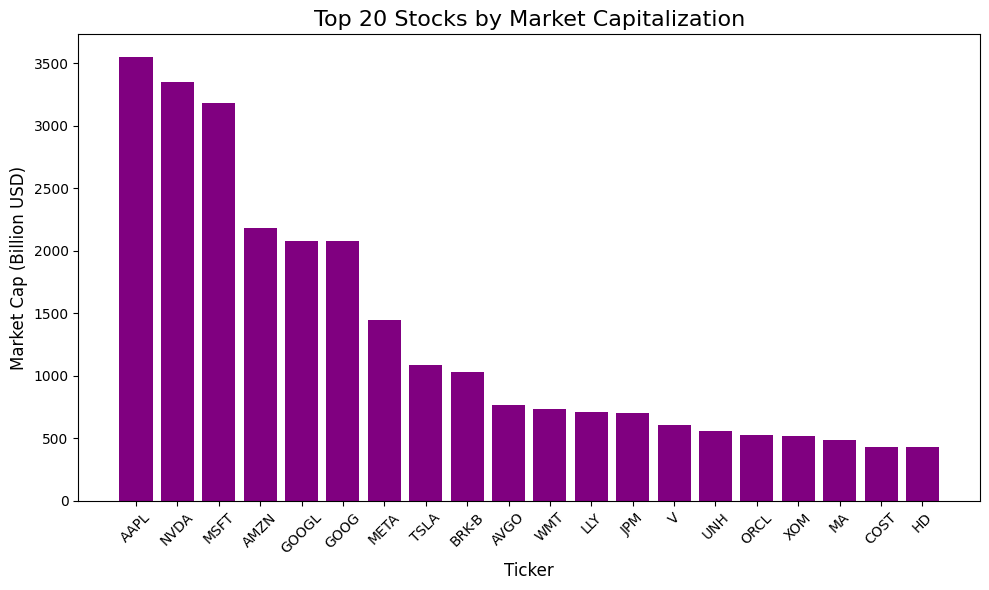

In [ ]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

# Setting the time interval
start_date = "2013-01-01"
end_date = "2023-12-31"

# Read a list of S&P 500 companies
sp500_file_path = 'sp500_companies.csv'
sp500_df = pd.read_csv(sp500_file_path)
sp500_tickers = sp500_df['Symbol'].tolist()

# Replace symbols to match Yahoo Finance format
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

stocks = []

for ticker in sp500_tickers:
    try:
        # download limit 3 times
        stock_data = None
        for attempt in range(3):
            try:
                stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                if not stock_data.empty:
                    break
                else:
                    raise ValueError("Empty data received")
            except Exception as e:
                if attempt < 2:
                    print(f"Attempt {attempt + 1} failed for {ticker}. Retrying after delay...")
                    time.sleep(5)  # try again after postpone
                else:
                    print(f"Failed to download data for {ticker} after 3 attempts.")
                    raise e

        # Check that the data is sufficiently complete
        if stock_data is None or stock_data.empty or len(stock_data) < 1000:
            print(f"Insufficient data for {ticker}: Data is empty or contains less than 1000 records ({len(stock_data)} records if not empty)\n")
            continue

        # Access to financial data
        stock = yf.Ticker(ticker)
        financials = stock.info
        market_cap = financials.get('marketCap', np.nan)

        # Checking the validity of market value data
        if not np.isnan(market_cap):
            stocks.append({
                'Ticker': ticker,
                'MarketCap': market_cap
            })
        else:
            print(f"Market cap data unavailable for {ticker}: Market cap is NaN\n")

    except KeyError as e:
        print(f"Data download failed for {ticker}: KeyError - {e}\n")
    except ValueError as e:
        print(f"ValueError for {ticker}: {e}\n")
    except Exception as e:
        print(f"Unexpected error while processing {ticker}: {e}\n")

# Converting data to DataFrame
stocks_df = pd.DataFrame(stocks)

# Filter and display the top 20 companies by market capitalisation
top_stocks_df = stocks_df.dropna(subset=['MarketCap']).sort_values(by='MarketCap', ascending=False).head(20)
print("Top 20 Stocks by Market Capitalization:")
print(top_stocks_df)

# Plotting a bar chart of the top 20 companies by market capitalisation
plt.figure(figsize=(10, 6))
plt.bar(top_stocks_df['Ticker'], top_stocks_df['MarketCap'] / 1e9, color='purple')
plt.title("Top 20 Stocks by Market Capitalization", fontsize=16)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Market Cap (Billion USD)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%***********************]  20 of 20 completed

Expected annual return of the optimal portfolio: 37.28%
Expected annual volatility of the optimal portfolio: 22.11%
Optimal Sharpe ratio: 1.60
Optimal weight allocation:
AVGO: 12.81%
COST: 12.83%
LLY: 31.77%
NVDA: 18.02%
TSLA: 11.92%
UNH: 12.64%


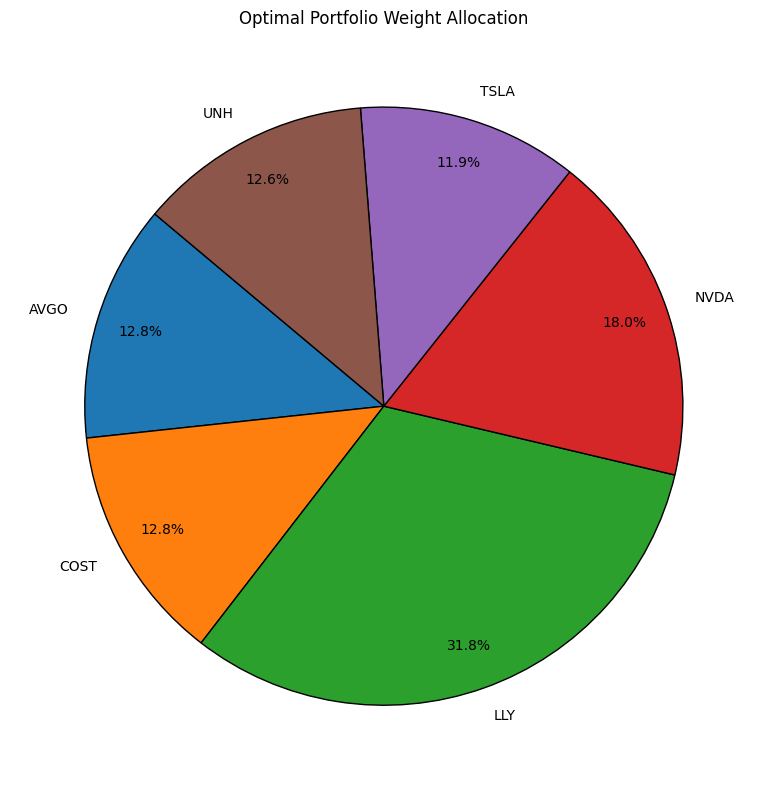

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import scipy.optimize as sco


# top 20 stocks
portfolio_tickers = [
    "NVDA", "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "META", "TSLA", "BRK-B", "AVGO", "LLY",
    "WMT", "JPM", "V", "UNH", "XOM", "ORCL", "MA", "COST", "HD"
]
# Download historical price data
start_date = "2013-01-01"
end_date = "2023-12-31"
data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close']

# Clean the data: fill missing values and drop columns/rows with all NaNs
data = data.ffill().bfill().dropna(how='all', axis=1).dropna(how='all', axis=0)

# Filter out tickers with insufficient data (less than 1000 trading days)
sufficient_data_tickers = data.columns[data.notna().sum() > 1000]
filtered_data = data[sufficient_data_tickers]

# If there are not enough tickers, exit early
if len(sufficient_data_tickers) < 2:
    print("Not enough tickers with sufficient data for optimization.")
    exit()

# Calculate daily returns
returns = filtered_data.pct_change().dropna()

# Calculate mean and covariance of returns
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Risk-free rate for Sharpe ratio calculation
risk_free_rate = 0.02

# Portfolio Performance Function
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
    returns = np.sum(mean_returns * weights) * 252
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (returns - risk_free_rate) / risk
    return returns, risk, sharpe_ratio

# Negative Sharpe Ratio Function for Optimization
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

# Constraints and Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(sufficient_data_tickers)))

# Initial Weights
initial_weights = len(sufficient_data_tickers) * [1. / len(sufficient_data_tickers)]

# Optimization to Maximize Sharpe Ratio
optimal_result = sco.minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                              method='SLSQP', bounds=bounds, constraints=constraints)

# Extract Optimal Weights
optimal_weights = optimal_result.x

# Filter out stocks with very small allocations (near 0%)
filtered_tickers = [ticker for ticker, weight in zip(sufficient_data_tickers, optimal_weights) if weight > 0.001]
filtered_weights = [weight for weight in optimal_weights if weight > 0.001]

# Output the Optimal Portfolio
opt_returns, opt_risk, opt_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix, risk_free_rate)

print("Expected annual return of the optimal portfolio: {:.2f}%".format(opt_returns * 100))
print("Expected annual volatility of the optimal portfolio: {:.2f}%".format(opt_risk * 100))
print("Optimal Sharpe ratio: {:.2f}".format(opt_sharpe))
print("Optimal weight allocation:")
for ticker, weight in zip(filtered_tickers, filtered_weights):
    print(f"{ticker}: {weight:.2%}")

# Visualize Optimal Portfolio Weight Allocation with an exploded view to prevent overlap
plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels=filtered_tickers, autopct='%1.1f%%', startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, pctdistance=0.85, labeldistance=1.1)
plt.title('Optimal Portfolio Weight Allocation')
plt.tight_layout()
plt.show()



In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")


Using CPU


In [ ]:
import yfinance as yf
import pandas as pd

# Download historical data for the portfolio tickers again (corrected to 'UNH')
portfolio_tickers = ['AVGO', 'COST', 'LLY', 'NVDA', 'TSLA', 'UNH']
start_date = '2013-01-01'
end_date = '2024-11-20'

# Download the data from Yahoo Finance
data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close']
data = data.fillna(method='ffill').fillna(method='bfill')

# Load the data to investigate UNH
unh_data = data['UNH']

# Check if there are any missing values and the overall summary of the data
unh_summary = unh_data.describe()
unh_missing_values = unh_data.isna().sum()

# Identify periods of zero or near-zero variation in the price data
unh_constant_periods = (unh_data.diff().abs() < 1e-5).sum()

print("Summary of UNH data:", unh_summary)
print("Missing values in UNH data:", unh_missing_values)
print("Number of periods with near-zero variation in UNH data:", unh_constant_periods)


[*********************100%***********************]  6 of 6 completed

Summary of UNH data: count    2992.000000
mean      259.907365
std       165.935963
min        42.915771
25%       105.056721
50%       226.376869
75%       438.254066
max       625.250000
Name: UNH, dtype: float64
Missing values in UNH data: 0
Number of periods with near-zero variation in UNH data: 8



C:\Users\a1669\AppData\Local\Temp\ipykernel_20840\513738570.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


[*********************100%***********************]  6 of 6 completed

Epoch 1/50


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0073 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.9475e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2951e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.4503e-04 - val_loss: 7.6617e-04 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2238e-04 - val_loss: 7.4540e-04 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 3.5648e-04 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 4.1747e-04 - val_loss: 8.2460e-04 - learning_rate: 0.0010
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 2.9400e-04 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 2.5906e-04 - val_loss: 0.0012 - lear

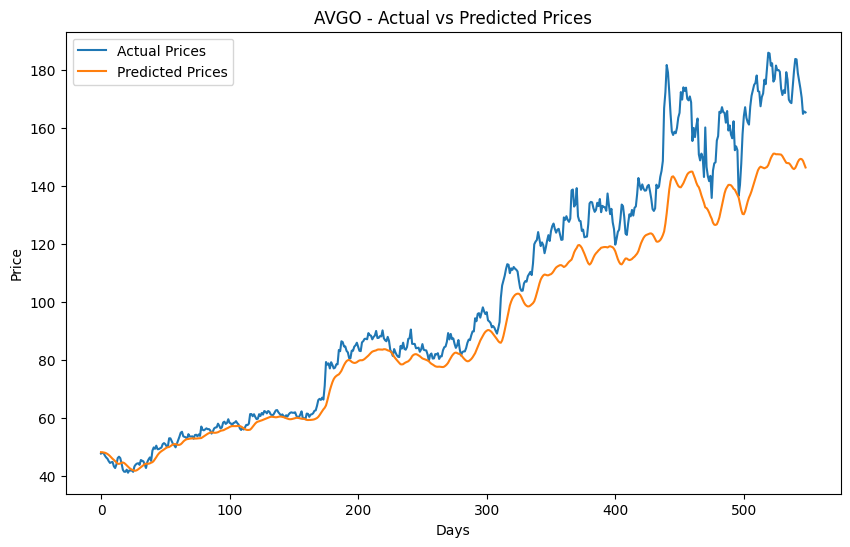

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

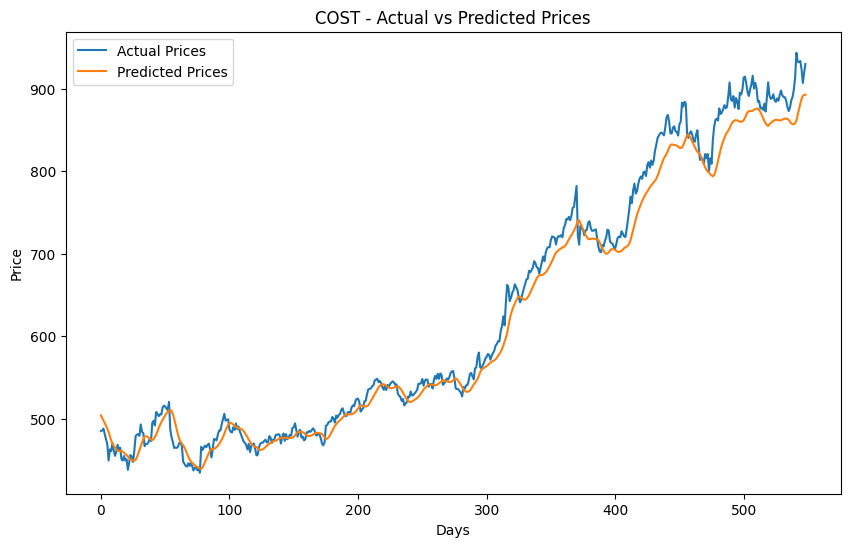

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

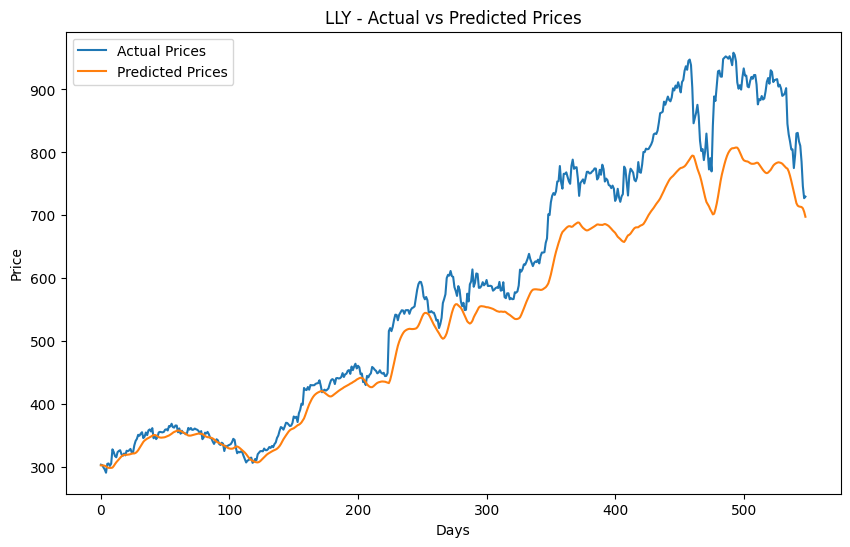

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0037 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.5306e-05 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0471e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0535e-04 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.0899e-05 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.4901e-05 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.5827e-05 - val_loss: 0.0028 - learning_rate: 5.0000e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.0799e-05 - val_loss: 0.0026 - learning_rate: 2.5000e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.9379e-05 - val_loss: 0.

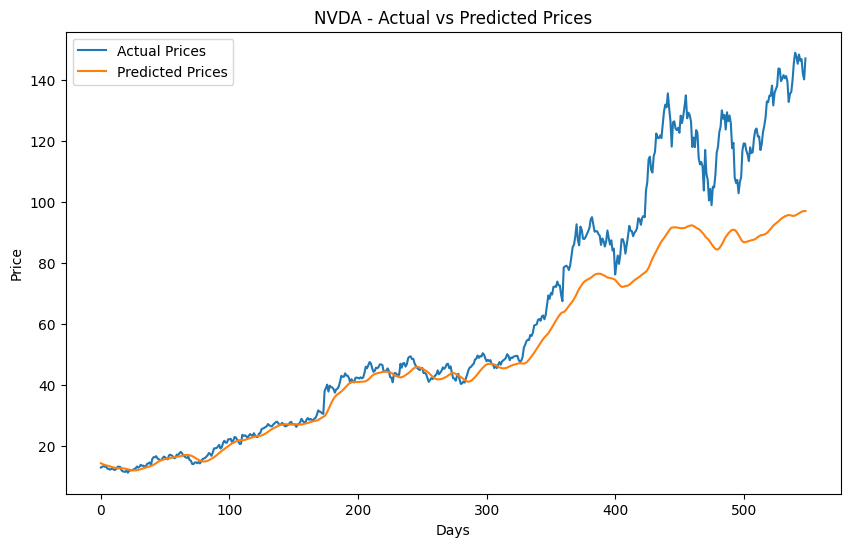

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

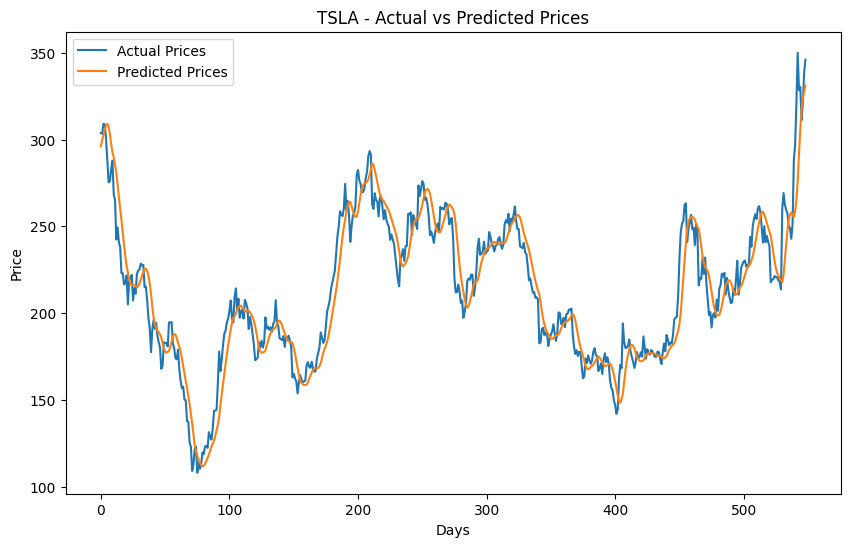

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

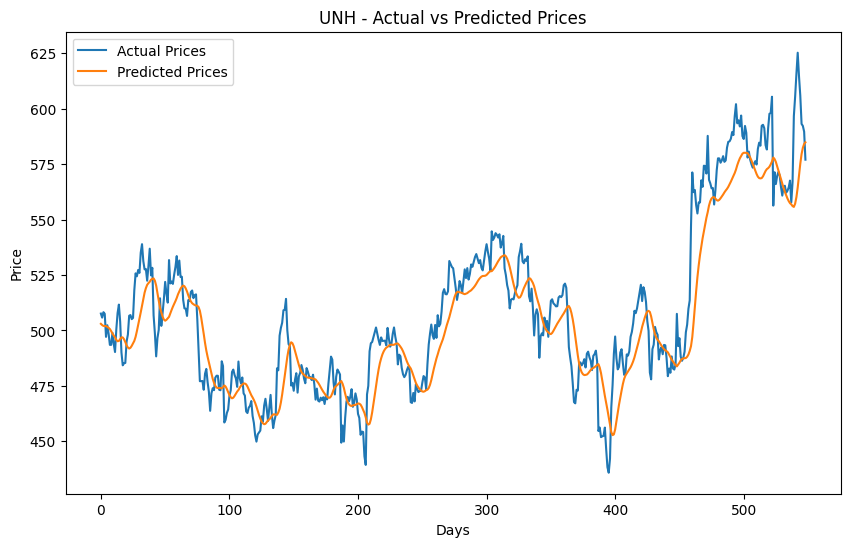

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

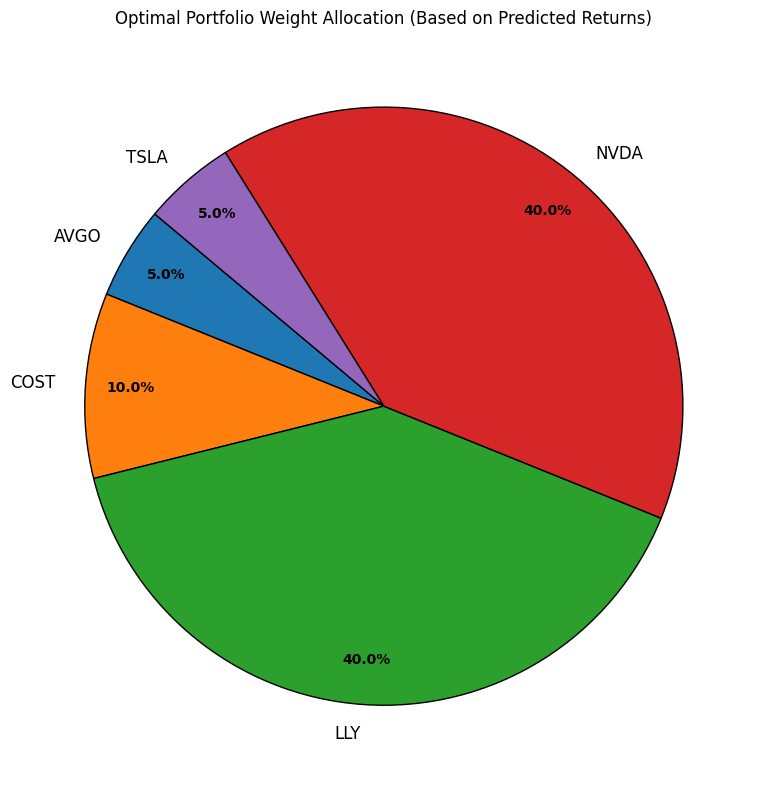

AVGO: 0.0500
COST: 0.1000
LLY: 0.4000
NVDA: 0.4000
TSLA: 0.0500


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
import scipy.optimize as sco
import datetime

portfolio_tickers = [
    'AVGO', 'COST', 'LLY', 'NVDA', 'TSLA', 'UNH'  # Corrected from 'UHN' to 'UNH'
]

# Data fetching
start_date = '2013-01-01'
end_date = '2024-11-20'

# Download historical data
data = yf.download(portfolio_tickers, start=start_date, end=end_date)['Adj Close']
data = data.ffill().bfill()  # Updated deprecated method call

# Initialize lists to hold predictions for each stock
future_predictions_list = []

# Iterate over each stock for individual analysis and prediction
for ticker in portfolio_tickers:
    # Extract the price data for the current stock
    stock_prices = data[ticker]

    # Split data into training and test sets
    train_size = int(len(stock_prices) * 0.8)
    train_stock, test_stock = stock_prices[:train_size], stock_prices[train_size:]

    # Scale data
    scaler_stock = MinMaxScaler(feature_range=(0, 1))
    train_stock_scaled = scaler_stock.fit_transform(train_stock.values.reshape(-1, 1))

    # Convert to LSTM format
    def create_lstm_dataset(dataset, look_back=50):
        X, y = [], []
        for i in range(look_back, len(dataset)):
            X.append(dataset[i-look_back:i, 0])
            y.append(dataset[i, 0])
        return np.array(X), np.array(y)

    X_train_stock, y_train_stock = create_lstm_dataset(train_stock_scaled)

    # Reshape input to be [samples, time steps, features]
    X_train_stock = X_train_stock.reshape((X_train_stock.shape[0], X_train_stock.shape[1], 1))

    # Create LSTM model
    def create_lstm_model(input_shape):
        inputs = Input(shape=input_shape)
        x = LSTM(128, return_sequences=True)(inputs)  # Reduced units to speed up training
        x = Dropout(0.2)(x)  # Reduced dropout rate to speed up training
        x = LSTM(128)(x)
        x = Dropout(0.2)(x)
        output = Dense(1)(x)
        model = Model(inputs, output)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Reduce learning rate on plateau and add early stopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)  # Reduced patience to speed up training
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Reduced patience to speed up training

    # Train LSTM model for the stock
    lstm_model_stock = create_lstm_model((X_train_stock.shape[1], 1))
    lstm_model_stock.fit(X_train_stock, y_train_stock, epochs=50, batch_size=32, verbose=1, validation_split=0.2, callbacks=[reduce_lr, early_stopping])  # Reduced epochs and batch size to speed up training

    # Make predictions for the test set
    if len(test_stock) > 50:
        test_stock_scaled = scaler_stock.transform(test_stock.values.reshape(-1, 1))
        X_test_stock, y_test_stock = create_lstm_dataset(test_stock_scaled)
        X_test_stock = X_test_stock.reshape((X_test_stock.shape[0], X_test_stock.shape[1], 1))
        
        # Predict and inverse transform
        y_pred_scaled = lstm_model_stock.predict(X_test_stock)
        y_pred = scaler_stock.inverse_transform(y_pred_scaled)
        y_test = scaler_stock.inverse_transform(y_test_stock.reshape(-1, 1))

        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Evaluation for {ticker} - MSE: {mse}, MAE: {mae}, R^2: {r2}")

        # Visualize predictions vs actual prices
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Actual Prices')
        plt.plot(y_pred, label='Predicted Prices')
        plt.title(f'{ticker} - Actual vs Predicted Prices')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # If metrics are satisfactory, proceed with future predictions
        if mse < 1e4 and mae < 50 and r2 > 0.7:
            future_steps = 252  # Assume 252 trading days in a year
            last_train_scaled = train_stock_scaled[-50:]
            future_predictions = []
            current_input = last_train_scaled

            for _ in range(future_steps):
                current_input = current_input.reshape((1, current_input.shape[0], 1))
                next_prediction = lstm_model_stock.predict(current_input)
                future_predictions.append(next_prediction[0, 0])
                current_input = np.append(current_input[0, 1:, 0], next_prediction[0, 0]).reshape(-1, 1)

            future_predictions = scaler_stock.inverse_transform(np.array(future_predictions).reshape(-1, 1))
            future_predictions_list.append(future_predictions)

# Calculate Expected Returns Based on Predictions
expected_returns = []
valid_tickers = []

for i, ticker in enumerate(portfolio_tickers):
    if i < len(future_predictions_list):  # Check to avoid index out of range error
        # Calculate expected annualized return based on predicted future prices
        predicted_prices = future_predictions_list[i]
        daily_returns = (predicted_prices[1:] - predicted_prices[:-1]) / predicted_prices[:-1]
        expected_annual_return = np.mean(daily_returns) * 252  # Assuming 252 trading days
        expected_returns.append(expected_annual_return)
        valid_tickers.append(ticker)  # Keep track of tickers with valid predictions

expected_returns = np.array(expected_returns)
print(f"Expected Returns for each stock: {expected_returns}")

# Align provided weights with valid tickers
provided_weights = [0.1279, 0.1284, 0.3178, 0.1802, 0.1192, 0.1265][:len(valid_tickers)]

# Portfolio optimization with expected returns
historical_returns = data[valid_tickers].pct_change().mean() * 252
cov_matrix = data[valid_tickers].pct_change().cov() * 252

# Objective function to minimize (negative Sharpe Ratio)
def negative_sharpe(weights, returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0.05, 0.4) for _ in range(len(valid_tickers)))  # Enforcing diversification by adding minimum and maximum weight constraints
initial_weights = provided_weights[:len(valid_tickers)]

# Calculate metrics for provided weights
provided_portfolio_return = np.dot(provided_weights, expected_returns)
provided_portfolio_volatility = np.sqrt(np.dot(provided_weights, np.dot(cov_matrix, provided_weights)))
provided_sharpe_ratio = (provided_portfolio_return - 0.01) / provided_portfolio_volatility

print(f"Provided Portfolio - Expected Return: {provided_portfolio_return:.4f}, Volatility: {provided_portfolio_volatility:.4f}, Sharpe Ratio: {provided_sharpe_ratio:.4f}")

# Optimize portfolio using expected returns
if len(expected_returns) == len(valid_tickers):  # Ensure expected returns are available for all tickers
    optimized_results = sco.minimize(negative_sharpe, initial_weights, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
    if optimized_results.success:
        optimized_weights = optimized_results.x

        # Calculate metrics for optimized portfolio
        optimized_portfolio_return = np.dot(optimized_weights, expected_returns)
        optimized_portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
        optimized_sharpe_ratio = (optimized_portfolio_return - 0.01) / optimized_portfolio_volatility

        print(f"Optimized Portfolio - Expected Return: {optimized_portfolio_return:.4f}, Volatility: {optimized_portfolio_volatility:.4f}, Sharpe Ratio: {optimized_sharpe_ratio:.4f}")

        # Visualize Optimal Portfolio Weight Allocation
        plt.figure(figsize=(12, 8))
        wedges, texts, autotexts = plt.pie(optimized_weights, labels=valid_tickers, autopct='%1.1f%%', startangle=140,
                                           wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, pctdistance=0.85, labeldistance=1.1)
        plt.setp(autotexts, size=10, weight='bold')
        plt.setp(texts, size=12)
        plt.title('Optimal Portfolio Weight Allocation (Based on Predicted Returns)')
        plt.tight_layout()
        plt.show()

        # Print optimized weights
        for ticker, weight in zip(valid_tickers, optimized_weights):
            print(f'{ticker}: {weight:.4f}')
    else:
        print("Optimization failed. No valid solution found.")
else:
    print("Expected returns not available for all tickers. Skipping optimization.")

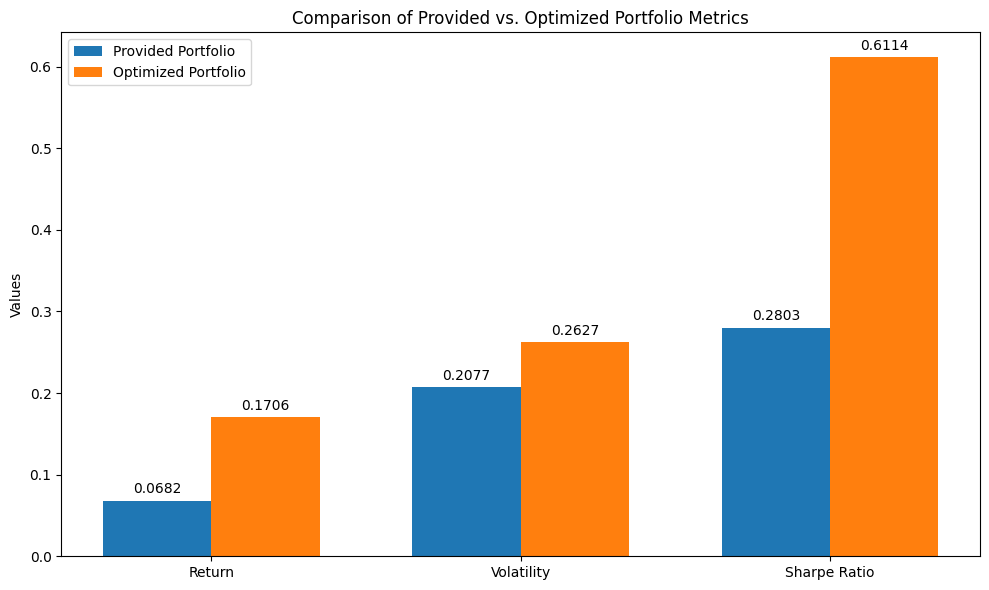

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Provided Portfolio Metrics
provided_portfolio_return = 0.0682  # Replace with the actual value from the output
provided_portfolio_volatility = 0.2077  # Replace with the actual value from the output
provided_sharpe_ratio = 0.2803  # Replace with the actual value from the output

# Optimized Portfolio Metrics
optimized_portfolio_return = 0.1706  # Replace with the actual value from the output
optimized_portfolio_volatility = 0.2627  # Replace with the actual value from the output
optimized_sharpe_ratio = 0.6114  # Replace with the actual value from the output

# Create a bar chart to visualize portfolio metrics
labels = ['Return', 'Volatility', 'Sharpe Ratio']
provided_metrics = [provided_portfolio_return, provided_portfolio_volatility, provided_sharpe_ratio]
optimized_metrics = [optimized_portfolio_return, optimized_portfolio_volatility, optimized_sharpe_ratio]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, provided_metrics, width, label='Provided Portfolio')
rects2 = ax.bar(x + width/2, optimized_metrics, width, label='Optimized Portfolio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Comparison of Provided vs. Optimized Portfolio Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for AVGO.
Successfully downloaded data for COST.
Successfully downloaded data for LLY.
Successfully downloaded data for NVDA.
Successfully downloaded data for TSLA.
Epoch 1/50



C:\Users\a1669\AppData\Local\Temp\ipykernel_5808\3795745005.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_prices.fillna(method='ffill', inplace=True)
C:\Users\a1669\AppData\Local\Temp\ipykernel_5808\3795745005.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  historical_prices.fillna(method='bfill', inplace=True)
d:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5558e-04 - val_loss: 0.0013
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.4164e-04 - val_loss: 8.4085e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.4793e-04 - val_loss: 0.0026
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.7759e-04 - val_loss: 8.1856e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.9171e-04 - val_loss: 0.0018
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5600e-04 - val_loss: 0.0012
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4557e-04 - val_loss: 5.2208e-04
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4664e-04 - val_loss: 0.0016
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3420e-04 - val_loss: 0.0011
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4153e-04 - val_loss: 0.0017
Epoch 12/50
68/68 ━━━━

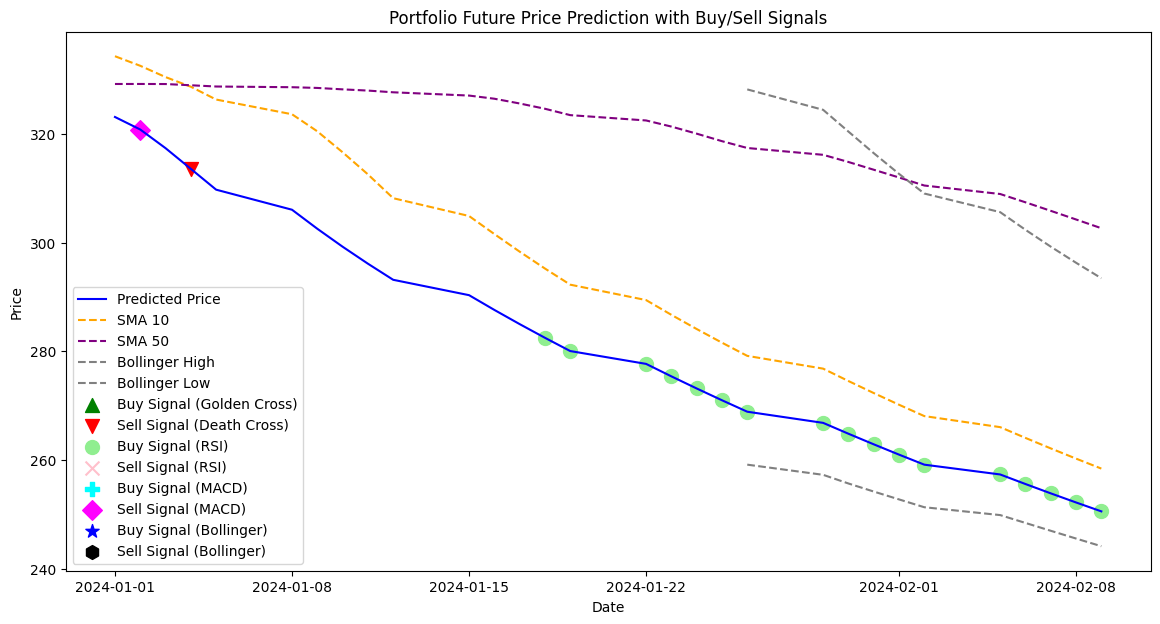

Future Predictions:
                           Predicted Price      SMA_10      SMA_50  \
2024-01-01 00:00:00+00:00       323.095306  334.269234  329.163412   
2024-01-02 00:00:00+00:00       320.791809  332.508635  329.167819   
2024-01-03 00:00:00+00:00       317.362762  330.435061  329.155192   
2024-01-04 00:00:00+00:00       313.556305  328.656961  328.929263   
2024-01-05 00:00:00+00:00       309.731354  326.302752  328.700615   
2024-01-08 00:00:00+00:00       306.043671  323.598628  328.570446   
2024-01-09 00:00:00+00:00       302.546783  320.460152  328.438345   
2024-01-10 00:00:00+00:00       299.245636  316.609351  328.177045   
2024-01-11 00:00:00+00:00       296.124451  312.548812  327.951997   
2024-01-12 00:00:00+00:00       293.161133  308.165921  327.636385   

                           Golden Cross  Death Cross  RSI  Buy Signal (RSI)  \
2024-01-01 00:00:00+00:00         False        False  NaN             False   
2024-01-02 00:00:00+00:00         False        Fals

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# portfolio and weight
portfolio_weights = {
    'AVGO': 0.05,
    'COST': 0.10,
    'LLY': 0.40,
    'NVDA': 0.40,
    'TSLA': 0.05
}

# download history 
def download_prices(tickers, start_date, end_date):
    prices = {}
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
            if not data.empty and 'Close' in data:
                prices[ticker] = data['Close']
                print(f"Successfully downloaded data for {ticker}.")
            else:
                print(f"No data found for {ticker}. Skipping.")
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
    if prices:
        return pd.concat(prices, axis=1)
    else:
        raise ValueError("No data downloaded. Please check the tickers and date range.")


start_date = "2013-01-01"
end_date = "2023-12-31" 
tickers = list(portfolio_weights.keys())
historical_prices = download_prices(tickers, start_date, end_date)


historical_prices.fillna(method='ffill', inplace=True)
historical_prices.fillna(method='bfill', inplace=True)

weights_series = pd.Series(portfolio_weights)


if isinstance(historical_prices.columns, pd.MultiIndex):
    historical_prices.columns = historical_prices.columns.get_level_values(0)


historical_prices = historical_prices[weights_series.index.intersection(historical_prices.columns)]


if not all(weights_series.index == historical_prices.columns):
    print("Mismatch detected:")
    print("weights_series.index:", weights_series.index)
    print("historical_prices.columns:", historical_prices.columns)
    raise ValueError("weights_series.index and historical_prices.columns are not aligned!")


historical_prices['Portfolio'] = historical_prices.dot(weights_series)


scaler = MinMaxScaler(feature_range=(0, 1))
historical_prices_scaled = scaler.fit_transform(historical_prices[['Portfolio']])

time_steps = 60
X, y = [], []
for i in range(time_steps, len(historical_prices_scaled)):
    X.append(historical_prices_scaled[i-time_steps:i])
    y.append(historical_prices_scaled[i])
X, y = np.array(X), np.array(y)


split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(50),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


future_steps = 30
future_data = historical_prices_scaled[-time_steps:]
future_predictions = []

for _ in range(future_steps):
    future_input = future_data[-time_steps:].reshape(1, time_steps, 1)
    predicted_price = model.predict(future_input)
    future_predictions.append(predicted_price[0, 0])
    future_data = np.append(future_data, predicted_price)[-time_steps:]


future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# forecast_dates
forecast_dates = pd.date_range(start=historical_prices.index[-1], periods=future_steps + 1, freq='B')[1:]
future_df = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Predicted Price'])

# future SMA_10  SMA_50
combined_data = pd.concat([historical_prices['Portfolio'], future_df['Predicted Price']])
future_df['SMA_10'] = combined_data.rolling(window=10, min_periods=1).mean().iloc[-len(future_df):]
future_df['SMA_50'] = combined_data.rolling(window=50, min_periods=1).mean().iloc[-len(future_df):]

# golden cross and death cross
future_df['Golden Cross'] = (future_df['SMA_10'] > future_df['SMA_50']) & (future_df['SMA_10'].shift(1) <= future_df['SMA_50'].shift(1))
future_df['Death Cross'] = (future_df['SMA_10'] < future_df['SMA_50']) & (future_df['SMA_10'].shift(1) >= future_df['SMA_50'].shift(1))

# RSI
delta = future_df['Predicted Price'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()
rs = average_gain / average_loss
future_df['RSI'] = 100 - (100 / (1 + rs))


future_df['Buy Signal (RSI)'] = future_df['RSI'] < 40  
future_df['Sell Signal (RSI)'] = future_df['RSI'] > 60  


short_window = 12
long_window = 26
signal_window = 9
future_df['MACD'] = future_df['Predicted Price'].ewm(span=short_window, adjust=False).mean() - \
                    future_df['Predicted Price'].ewm(span=long_window, adjust=False).mean()
future_df['Signal Line'] = future_df['MACD'].ewm(span=signal_window, adjust=False).mean()

future_df['Buy Signal (MACD)'] = (future_df['MACD'] > future_df['Signal Line']) & \
                                 (future_df['MACD'].shift(1) <= future_df['Signal Line'].shift(1))
future_df['Sell Signal (MACD)'] = (future_df['MACD'] < future_df['Signal Line']) & \
                                  (future_df['MACD'].shift(1) >= future_df['Signal Line'].shift(1))

future_df['Rolling Mean'] = future_df['Predicted Price'].rolling(window=20).mean()
future_df['Bollinger High'] = future_df['Rolling Mean'] + (future_df['Predicted Price'].rolling(window=20).std() * 2)
future_df['Bollinger Low'] = future_df['Rolling Mean'] - (future_df['Predicted Price'].rolling(window=20).std() * 2)

future_df['Buy Signal (Bollinger)'] = future_df['Predicted Price'] < future_df['Bollinger Low']
future_df['Sell Signal (Bollinger)'] = future_df['Predicted Price'] > future_df['Bollinger High']

plt.figure(figsize=(14, 7))

plt.plot(future_df['Predicted Price'], label='Predicted Price', color='blue')
plt.plot(future_df['SMA_10'], label='SMA 10', linestyle='--', color='orange')
plt.plot(future_df['SMA_50'], label='SMA 50', linestyle='--', color='purple')
plt.plot(future_df['Bollinger High'], label='Bollinger High', linestyle='--', color='grey')
plt.plot(future_df['Bollinger Low'], label='Bollinger Low', linestyle='--', color='grey')

buy_signals_golden = future_df[future_df['Golden Cross']]
sell_signals_death = future_df[future_df['Death Cross']]
buy_signals_rsi = future_df[future_df['Buy Signal (RSI)']]
sell_signals_rsi = future_df[future_df['Sell Signal (RSI)']]
buy_signals_macd = future_df[future_df['Buy Signal (MACD)']]
sell_signals_macd = future_df[future_df['Sell Signal (MACD)']]
buy_signals_bollinger = future_df[future_df['Buy Signal (Bollinger)']]
sell_signals_bollinger = future_df[future_df['Sell Signal (Bollinger)']]

plt.scatter(buy_signals_golden.index, buy_signals_golden['Predicted Price'], label='Buy Signal (Golden Cross)', color='green', marker='^', s=100)
plt.scatter(sell_signals_death.index, sell_signals_death['Predicted Price'], label='Sell Signal (Death Cross)', color='red', marker='v', s=100)
plt.scatter(buy_signals_rsi.index, buy_signals_rsi['Predicted Price'], label='Buy Signal (RSI)', color='lightgreen', marker='o', s=100)
plt.scatter(sell_signals_rsi.index, sell_signals_rsi['Predicted Price'], label='Sell Signal (RSI)', color='pink', marker='x', s=100)
plt.scatter(buy_signals_macd.index, buy_signals_macd['Predicted Price'], label='Buy Signal (MACD)', color='cyan', marker='P', s=100)
plt.scatter(sell_signals_macd.index, sell_signals_macd['Predicted Price'], label='Sell Signal (MACD)', color='magenta', marker='D', s=100)
plt.scatter(buy_signals_bollinger.index, buy_signals_bollinger['Predicted Price'], label='Buy Signal (Bollinger)', color='blue', marker='*', s=100)
plt.scatter(sell_signals_bollinger.index, sell_signals_bollinger['Predicted Price'], label='Sell Signal (Bollinger)', color='black', marker='h', s=100)

plt.title('Portfolio Future Price Prediction with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("Future Predictions:")
print(future_df.head(10))


